## Họ và tên: Nguyễn Mạnh Niên
## Mã sinh viên: 2022601951
## Lớp: 2022601951

In [43]:
# Cài đặt các thư viện cần thiết
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Loại bỏ các cảnh báo
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [62]:
# Khai báo các giá trị tham số cố định
PATH_FILE       = 'Hill_valley.csv' # Đường dẫn đến file dữ liệu
RANDOM_STATE    = 42                # Dùng trong chia dữ liệu
TEST_SIZE       = 0.25              # Dùng trong chia dữ liệu
K_FOLD          = 10                # Dùng trong đánh giá kiểm định chéo
CV              = 5                 # Dùng trong quá trình tìm kiếm tham số tốt nhất
DPI             = 200               # Độ phân giải cho biểu đồ

In [45]:
# Đọc dữ liệu sử dụng pandas
try:
    # Đọc file CSV
    df = pd.read_csv(PATH_FILE,
                     header = 0, 
                     sep = ',',
                     skipinitialspace = True)
    print('Đọc file thành công!')
    print(df.head(5))   # In ra 5 dòng đầu tiên
except FileNotFoundError:
    print(f"Lỗi: File '{PATH_FILE}' không tồn tại.")
except Exception:
    print(f"Lỗi {Exception}.")

Đọc file thành công!
          0         1         2         3         4         5         6  \
0     39.02     36.49     38.20     38.85     39.38     39.74     37.02   
1      1.83      1.71      1.77      1.77      1.68      1.78      1.80   
2  68177.69  66138.42  72981.88  74304.33  67549.66  69367.34  69169.41   
3  44889.06  39191.86  40728.46  38576.36  45876.06  47034.00  46611.43   
4      5.70      5.40      5.28      5.38      5.27      5.61      6.00   

          7         8         9  ...        91        92        93        94  \
0     39.53     38.81     38.79  ...     36.62     36.92     38.80     38.52   
1      1.70      1.75      1.78  ...      1.80      1.79      1.77      1.74   
2  73268.61  74465.84  72503.37  ...  73438.88  71053.35  71112.62  74916.48   
3  37668.32  40980.89  38466.15  ...  42625.67  40684.20  46960.73  44546.80   
4      5.38      5.34      5.87  ...      5.17      5.67      5.60      5.94   

         95        96        97        98      

#### Kiểm tra thông tin dữ liệu

In [46]:
# Kiểm tra xem dữ liệu có bị thiếu hay không
check_nan = df.isna().any().any()
if check_nan == True:
    print("Dữ liệu bị thiếu!")
else:
    print("Dữ liệu đầy đủ!")

Dữ liệu đầy đủ!


100
0    606
1    606
Name: count, dtype: int64


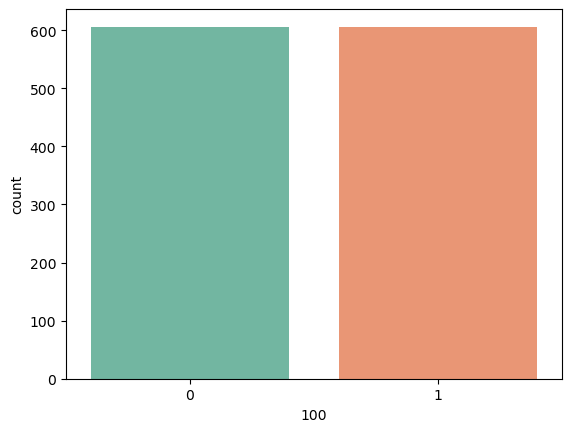

In [47]:
# Kiểm tra tính cân bằng của nhãn
print(df['100'].value_counts())
sns.countplot(data=df, x = '100', palette='Set2');

#### Tiền xử lý dữ liệu

In [48]:
# Chuyển đổi các thuộc tính dạng ký tự sang số
Le = LabelEncoder()
df['100'] = Le.fit_transform(df['100'])

In [49]:
# Chuẩn hóa Min-Max
# Lấy dữ liệu chuẩn hóa từ DataFrame
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]

# Chuẩn hóa dữ liệu
scaler  = MinMaxScaler()
df_X    = scaler.fit_transform(df_X)

#### Chuẩn bị dữ liệu huấn luyện

In [50]:
# Đánh giá theo phương pháp chia tỷ lệ
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE)

# Kiểm tra chiều dữ liệu
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(909, 100)
(303, 100)
(909,)
(303,)


#### Huấn luyện mô hình

In [51]:
# Khởi tạo mô hình
clf = SVC()

# Huấn luyện mô hình
start_time = time.time()
clf.fit(X_train, y_train)
execution_time = time.time() - start_time
print(f"Thời gian huấn luyện mô hình: {execution_time:.5f} giây.")

# Dự đoán mô hình
y_pred = clf.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy * 100:.5f}%.")

Thời gian huấn luyện mô hình: 0.04981 giây.
Độ chính xác của mô hình: 49.83498%.


#### Sử dụng GridSearchCV để tìm kiếm 1 bộ tham số cho mô hình

In [52]:
# Khởi tạo lưới tham số
grid_parameters = {
    'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],    # Các dạng hàm kernel
    'C'      : [0, 0.1, 1, 10, 100],                    # Tham số phạt của mô hình
    'coef0'  : [1, 2, 3, 4],                            # Tham số gamma của đa thức
    'degree' : [1, 2, 3, 4]                             # Bậc của đa thức
}

In [53]:
# Tìm kiếm tham số
gridSearch = GridSearchCV(estimator     = clf, 
                          param_grid    = grid_parameters, 
                          scoring       = 'accuracy',
                          cv            = CV,
                          verbose       = 2,
                          refit         = True)
gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END ................C=0, coef0=1, degree=1, kernel=poly; total time=   0.0s
[CV] END ................C=0, coef0=1, degree

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 0.1, 1, 10, 100], 'coef0': [1, 2, 3, 4],
                         'degree': [1, 2, 3, 4],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [54]:
# Đưa ra tham số tốt nhất và độ chính xác cao nhất khi dùng GridSearchCV

# In ra bộ tham số tham số tốt nhất
best_params = gridSearch.best_params_
print(f"Bộ tham số tốt nhất của mô hình: {best_params}.")

# In ra độ chính xác cao nhất của mô hình
print(f"Độ chính xác cao nhất của mô hình: {gridSearch.best_score_ * 100:.5f}%.")

Bộ tham số tốt nhất của mô hình: {'C': 100, 'coef0': 4, 'degree': 4, 'kernel': 'poly'}.
Độ chính xác cao nhất của mô hình: 69.63572%.


#### Đánh giá lại mô hình

Thời gian huấn luyện mô hình: 0.10180 giây.
              precision    recall  f1-score   support

           0       0.61      0.95      0.74       142
           1       0.91      0.47      0.62       161

    accuracy                           0.69       303
   macro avg       0.76      0.71      0.68       303
weighted avg       0.77      0.69      0.68       303



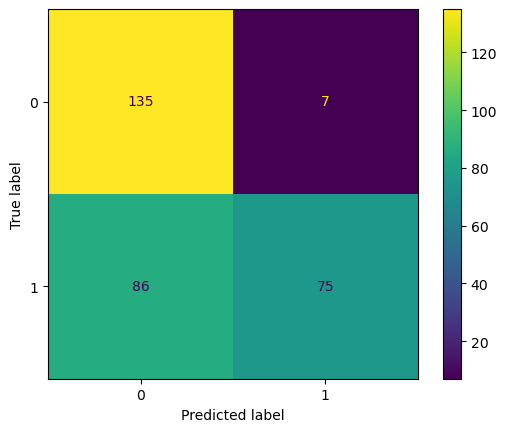

In [55]:
# Khởi tạo lại mô hình với bộ tham số tìm được
clf = SVC(**best_params)
start_time = time.time()
clf.fit(X_train, y_train)
finish = time.time() - start_time
print(f"Thời gian huấn luyện mô hình: {finish:.5f} giây.")

# Đánh giá mô hình
y_pred = clf.predict(X_test)

# Đưa ra báo cáo đánh giá
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict = True)

# In ra ma trận confusion
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

#### Cách 1: Sử dụng phép tính bình thường theo công thức
* Quy ước: 0 là possitive và 1 là negative

In [59]:
# True Possitive
TP = np.sum((y_test == 0) & (y_pred == 0))
# False Possitive
FP = np.sum((y_test == 1) & (y_pred == 0))
# False Negative
FN = np.sum((y_test == 0) & (y_pred == 1))
# True Negative
TN = np.sum((y_test == 1) & (y_pred == 1))

print("{:<18}:  {:>5}".format('True Possitive', TP))
print("{:<18}:  {:>5}".format('True Negative', TN))
print("{:<18}:  {:>5}".format('False Possitive', FP))
print("{:<18}:  {:>5}".format('False Negative', FN))

# Tính các giá trị precision, recall, f1-score
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1Score   = 2 * (precision * recall) / (precision + recall)
print("{:<18}:  {:>5.5f}".format('Precision', precision))
print("{:<18}:  {:>5.5f}".format('Recall', recall))
print("{:<18}:  {:>5.5f}".format('f1-score', f1Score))


True Possitive    :    135
True Negative     :     75
False Possitive   :     86
False Negative    :      7
Precision         :  0.61086
Recall            :  0.95070
f1-score          :  0.74380


#### Cách 2: Sử dụng thư viện, truy xuất tới các giá trị của report

In [60]:
# Kiểm tra các địa chỉ truy cập của report
print(report.keys())

# Truy cập tới các giá trị
precision = report['0']['precision']
recall    = report['0']['recall']
f1Score   = report['0']['f1-score']
accuracy  = report['accuracy']

# Hiển thị kết quả
print("{:<18}:  {:>5.5f}".format('Precision', precision))
print("{:<18}:  {:>5.5f}".format('Recall', recall))
print("{:<18}:  {:>5.5f}".format('f1-score', f1Score))
print("{:<18}:  {:>5.5f}".format('Accuracy', accuracy))

dict_keys(['0', '1', 'accuracy', 'macro avg', 'weighted avg'])
Precision         :  0.61086
Recall            :  0.95070
f1-score          :  0.74380
Accuracy          :  0.69307


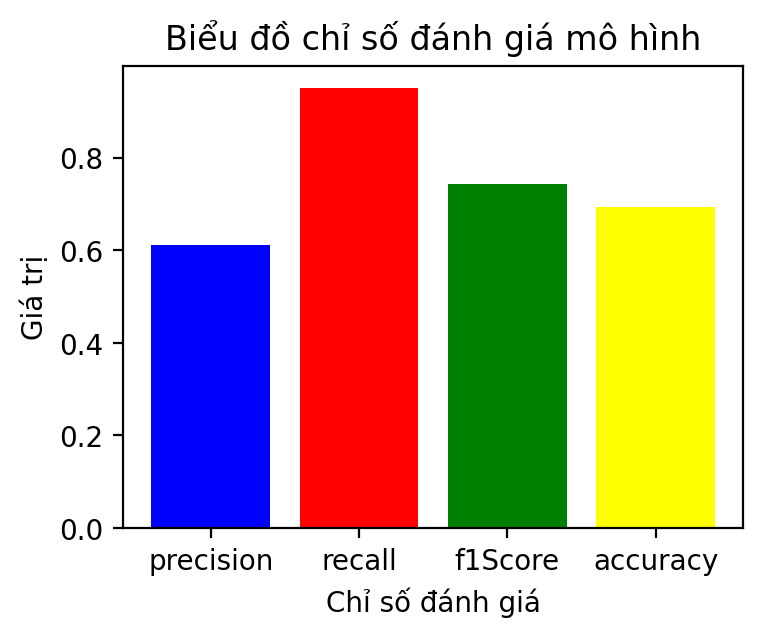

In [64]:
# Biểu diễn các giá trị trên đồ thị
labels = ['precision', 'recall', 'f1Score', 'accuracy']
values = [precision, recall, f1Score, accuracy]

# Gán màu cho từng cột
colors = ['blue', 'red', 'green', 'yellow']

# Tạo figure với độ phân giải cao, tham số dpi
plt.figure(figsize = (4, 3), dpi = DPI)

# Chọn biểu đồ cột
plt.bar(labels, values, color = colors)

# Thêm tiêu đề cho biểu đồ cột
plt.title('Biểu đồ chỉ số đánh giá mô hình')
plt.xlabel('Chỉ số đánh giá')
plt.ylabel('Giá trị')
# plt.grid()          # Thêm lưới cho biểu đồ

# Vẽ biểu đồ
plt.show()

#### Đánh giá mô hình theo phương pháp kiểm định chéo

In [66]:
# Khởi tạo hàm kiểm định chéo
kf = KFold(n_splits = K_FOLD, 
           shuffle = True, 
           random_state = RANDOM_STATE)

accuracies = []
precisions = []
recalls    = []
f1_scores  = []

i = 1

for train_index, test_index in kf.split(df_X):
    start_time = time.time()

    # Chia dữ liệu thành training và testing
    X_train, X_test = df_X[train_index], df_X[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]

    print(X_train.shape)
    print(X_test.shape)

    # Khởi tạo mô hình
    clf = SVC(**best_params)

    # Huấn luyện mô hình
    clf.fit(X_train, y_train)
    finish = time.time() - start_time

    # Dự đoán mô hình
    y_pred = clf.predict(X_test)

    # Đưa ra độ chính xác của mô hình
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1Score   = f1_score(y_test, y_pred)

    # In ra kết quả
    print(f'FOLD: {i}')
    print('{:<15} : {:>5.5f}'.format("Accuracy", accuracy))
    print('{:<15} : {:>5.5f}'.format("Precision", precision))
    print('{:<15} : {:>5.5f}'.format("Recall", recall))
    print('{:<15} : {:>5.5f}'.format("F1-Score", f1Score))
    print("=========================================================")

    # Append vào các mảng
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1Score)

    i = i + 1

(1090, 100)
(122, 100)
FOLD: 1
Accuracy        : 0.67213
Precision       : 0.96667
Recall          : 0.42647
F1-Score        : 0.59184
(1090, 100)
(122, 100)
FOLD: 2
Accuracy        : 0.70492
Precision       : 0.89474
Recall          : 0.51515
F1-Score        : 0.65385
(1091, 100)
(121, 100)
FOLD: 3
Accuracy        : 0.74380
Precision       : 0.90000
Recall          : 0.49091
F1-Score        : 0.63529
(1091, 100)
(121, 100)
FOLD: 4
Accuracy        : 0.66942
Precision       : 0.86207
Recall          : 0.40984
F1-Score        : 0.55556
(1091, 100)
(121, 100)
FOLD: 5
Accuracy        : 0.69421
Precision       : 0.96774
Recall          : 0.45455
F1-Score        : 0.61856
(1091, 100)
(121, 100)
FOLD: 6
Accuracy        : 0.72727
Precision       : 0.96875
Recall          : 0.49206
F1-Score        : 0.65263
(1091, 100)
(121, 100)
FOLD: 7
Accuracy        : 0.78512
Precision       : 1.00000
Recall          : 0.42222
F1-Score        : 0.59375
(1091, 100)
(121, 100)
FOLD: 8
Accuracy        : 0.7190

In [67]:
# Tính các giá trị trung bình
mean_accuracy  = np.mean(accuracies)
std_acc        = np.std(accuracies)

mean_precision = np.mean(precisions)
std_pre        = np.std(precisions)

mean_recall    = np.mean(recalls)
std_rec        = np.std(recalls)

mean_f1_score  = np.mean(f1_scores)
std_f1         = np.std(f1_scores)

print("{:<18} : {:>5.5f} +- {:>5.5f}".format("Mean Accuracy", mean_accuracy, std_acc))
print("{:<18} : {:>5.5f} +- {:>5.5f}".format("Mean Precision", mean_precision, std_pre))
print("{:<18} : {:>5.5f} +- {:>5.5f}".format("Mean Recall", mean_recall, std_rec))
print("{:<18} : {:>5.5f} +- {:>5.5f}".format("Mean F1-score", mean_f1_score, std_f1))

Mean Accuracy      : 0.70878 +- 0.03435
Mean Precision     : 0.93759 +- 0.04072
Mean Recall        : 0.44807 +- 0.03724
Mean F1-score      : 0.60512 +- 0.03365
